In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

In [3]:
%store -r trainDF
%store -r cleaned_trainDF_Isolation
%store -r cleaned_trainDF_Mahalanobis

# -------------------------------------------------------------------------------------

# Isolation Forest Anomaly Removal Random Forest Model

In [4]:
X_cleaned_Isolation = cleaned_trainDF_Isolation.drop(columns=['isFraud'])  # Features
y_cleaned_Isolation = trainDF.loc[cleaned_trainDF_Isolation.index, 'isFraud']  # Target
X_train_isolation, X_test_isolation, y_train_isolation, y_test_isolation = train_test_split(X_cleaned_Isolation, y_cleaned_Isolation, test_size=0.3, random_state=0, stratify=y_cleaned_Isolation)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
model.fit(X_train_isolation, y_train_isolation)
y_pred_isolation = model.predict(X_test_isolation)
print("Accuracy:", accuracy_score(y_test_isolation, y_pred_isolation))
print("Classification Report:\n", classification_report(y_test_isolation, y_pred_isolation))

Accuracy: 0.9789897520163566
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    155971
           1       0.97      0.04      0.07      3475

    accuracy                           0.98    159446
   macro avg       0.97      0.52      0.53    159446
weighted avg       0.98      0.98      0.97    159446



In [5]:
conf_matrix = confusion_matrix(y_test_isolation, y_pred_isolation)
tn, fp, fn, tp = conf_matrix.ravel()
type_1_error_rate = fp / (fp + tn) 
type_2_error_rate = fn / (fn + tp)
print(f"Type 1 Error Rate (False Positive Rate): {type_1_error_rate}")
print(f"Type 2 Error Rate (False Negative Rate): {type_2_error_rate}")

Type 1 Error Rate (False Positive Rate): 2.564579312820973e-05
Type 2 Error Rate (False Negative Rate): 0.9628776978417266


# ------------------------------------------------------------------------------------

# Mahalanobis Outlier Removal Random Forest Model

In [6]:
X = cleaned_trainDF_Mahalanobis.drop(columns=['isFraud'])  # Features
y = trainDF.loc[cleaned_trainDF_Mahalanobis.index, 'isFraud']  # Target
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)  # You can adjust n_estimators as needed
model.fit(X_train_m, y_train_m) 

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)

In [7]:
y_pred_m = model.predict(X_test_m)
conf = confusion_matrix(y_test_m, y_pred_m)
print("Confusion Matrix:")
print(conf)

accuracy = accuracy_score(y_test_m, y_pred_m)
print(f"Accuracy: {accuracy:.4f}")

tn, fp, fn, tp = conf.ravel()
type_1_error_rate = fp / (fp + tn)  # False Positive Rate
type_2_error_rate = fn / (fn + tp)  # False Negative Rate

print(f"Type 1 Error Rate (False Positive Rate): {type_1_error_rate}")
print(f"Type 2 Error Rate (False Negative Rate): {type_2_error_rate}")

Confusion Matrix:
[[170843    120]
 [  4547   1652]]
Accuracy: 0.9737
Type 1 Error Rate (False Positive Rate): 0.0007019062604189211
Type 2 Error Rate (False Negative Rate): 0.733505404097435


# ------------------------------------------------------------------------------------

# Removal of Outliers (Mahalanobis + Isolation Forest)

In [8]:
filtered_trainDF = trainDF.merge(cleaned_trainDF_Mahalanobis[['TransactionID']], on='TransactionID')
filtered_trainDF = filtered_trainDF.merge(cleaned_trainDF_Isolation[['TransactionID']], on='TransactionID')

# ------------------------------------------------------------------------------------

# CART Tree Classification + SMOTE

In [9]:
# Prepare the data: Define features (X) and target (y)
X = filtered_trainDF.drop(columns=['isFraud'])  # Features (drop the target column)
y = filtered_trainDF['isFraud']  # Target

# Handle Timestamp columns (convert them to numeric if necessary)
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in str(X[col].dtype):
        X[col] = X[col].astype('int64')  # Convert datetime to int (timestamps)

# Convert categorical columns to numeric using Label Encoding (for simplicity)
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' or isinstance(X[column].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Replace infinite or very large values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values for numeric columns with column mean, and categorical columns with mode
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:  # For numeric columns
        X[col] = X[col].fillna(X[col].mean())  # Assign the filled result back to the column
    else:  # For categorical columns, fill with the most frequent value
        X[col] = X[col].fillna(X[col].mode()[0])  # Assign the filled result back to the column

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CART model (DecisionTreeClassifier)
cart_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
cart_model.fit(X_train, y_train)

# Predict on the test data
y_pred_cart = cart_model.predict(X_test)

# Evaluate the model
accuracy_cart = accuracy_score(y_test, y_pred_cart)
classification_report_cart = classification_report(y_test, y_pred_cart)

# Print results
print(f"Accuracy of CART model: {accuracy_cart}")
print(f"Classification Report for CART model:\n{classification_report_cart}")


Accuracy of CART model: 0.9748631206607838
Classification Report for CART model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    103955
           1       0.43      0.46      0.45      2343

    accuracy                           0.97    106298
   macro avg       0.71      0.72      0.72    106298
weighted avg       0.98      0.97      0.98    106298



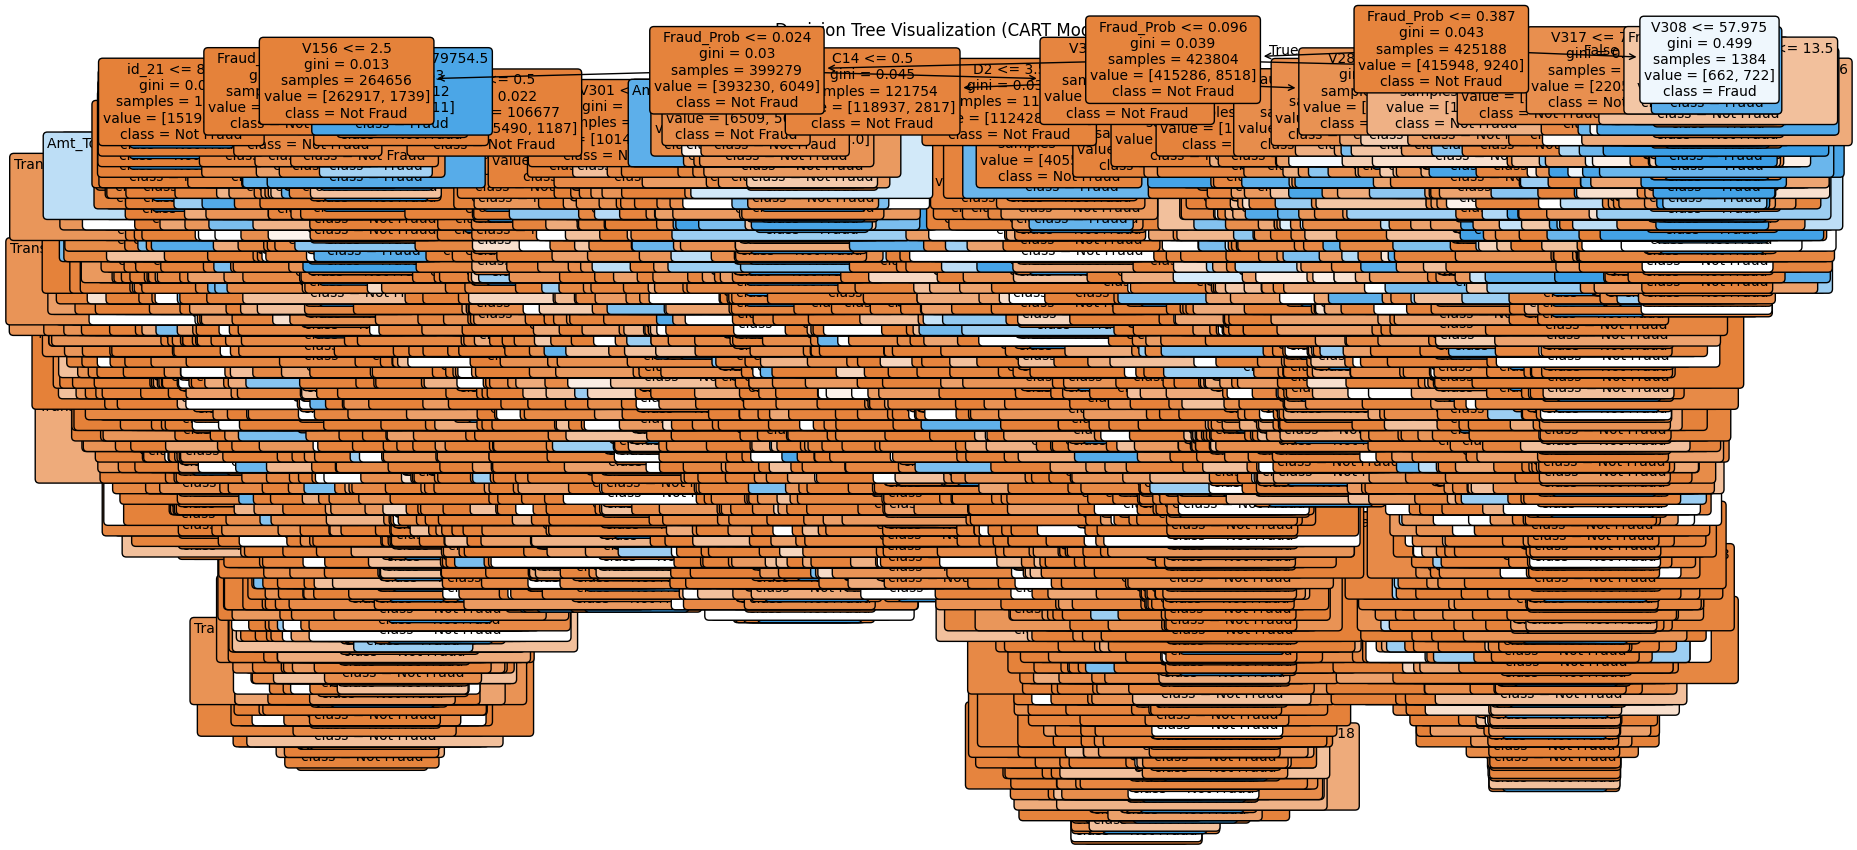

In [10]:
plt.figure(figsize=(20, 10))  # Adjust the size of the plot
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          feature_names=X.columns,  # Use feature names for clarity
          class_names=['Not Fraud', 'Fraud'],  # Use class names
          fontsize=10)

plt.title("Decision Tree Visualization (CART Model)")
plt.show()

In [11]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
cart_model.fit(X_train_res, y_train_res)
y_pred_cart = cart_model.predict(X_test)
accuracy_cart = accuracy_score(y_test, y_pred_cart)
classification_report_cart = classification_report(y_test, y_pred_cart)
print(f"Accuracy of CART model: {accuracy_cart}")
print(f"Classification Report for CART model:\n{classification_report_cart}")

Accuracy of CART model: 0.9689363863854447
Classification Report for CART model:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    103955
           1       0.33      0.41      0.37      2343

    accuracy                           0.97    106298
   macro avg       0.66      0.70      0.68    106298
weighted avg       0.97      0.97      0.97    106298



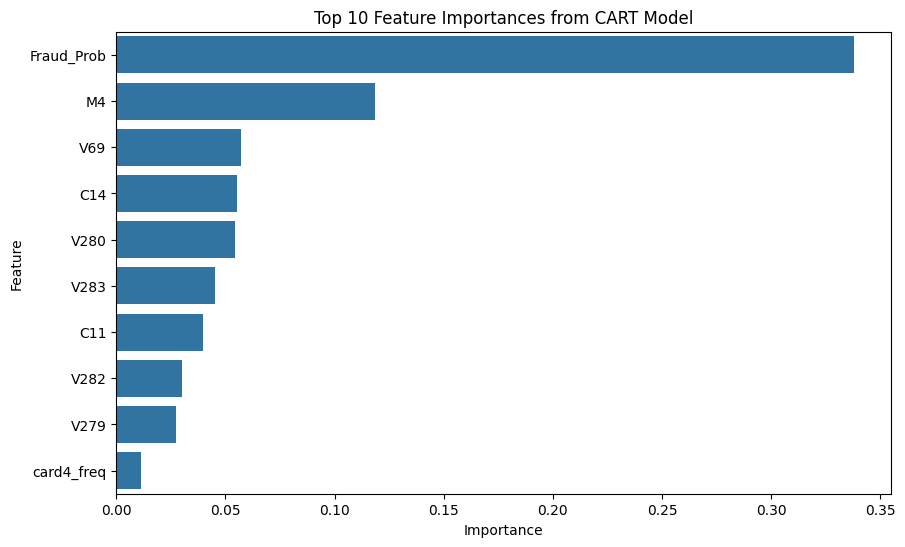

In [12]:
top_n = 10
feature_importances = pd.Series(cart_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n)

# Plot the top N features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'Top {top_n} Feature Importances from CART Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ------------------------------------------------------------------------------------

# XGBoost Model

In [13]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)

y_pred = xgb_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:19:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy:  0.9842518203540989
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    103955
           1       0.85      0.35      0.49      2343

    accuracy                           0.98    106298
   macro avg       0.92      0.67      0.74    106298
weighted avg       0.98      0.98      0.98    106298

